# Assignment 5: Epipolar geometry and triangulation

In [67]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

### Exercise 1: Disparity

#### a) Derive teh expression for disparity which is defined as d = x1 - x2

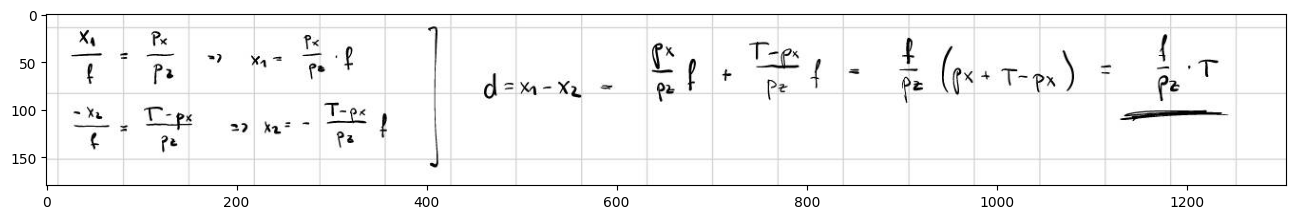

In [68]:
res = cv2.imread("1a.jpg")
fig, ax = plt.subplots(1,1,figsize=(16,5))
ax.imshow(res)


Disparity is inversely proportional to the z distance from the object - depth. When the object is close, disparity is high, when it is far, disparity is low (depth = high, disparity = low). 

#### b) Compute disparity for a range of values of p

Text(0, 0.5, 'disparity [cm]')

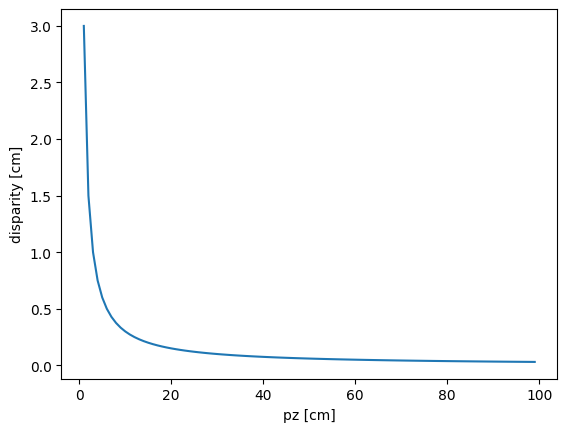

In [69]:
def disparity(z_coord, focal_length=.25, T_baseline=12):
    '''
        Computes disparity for a given z coordinate of a point, focal length and baseline are in cm
    '''
    if z_coord == 0:
        return 9999999999999999
    return focal_length * T_baseline / z_coord

disparities = []
pz = [i for i in range(1, 100)]

for p in pz:
    disparities.append(disparity(p))
    
plt.plot(pz, disparities)
plt.xlabel("pz [cm]")
plt.ylabel("disparity [cm]")    # Or px if focal length is in pixels

#### c) Bumblebee2 disparity

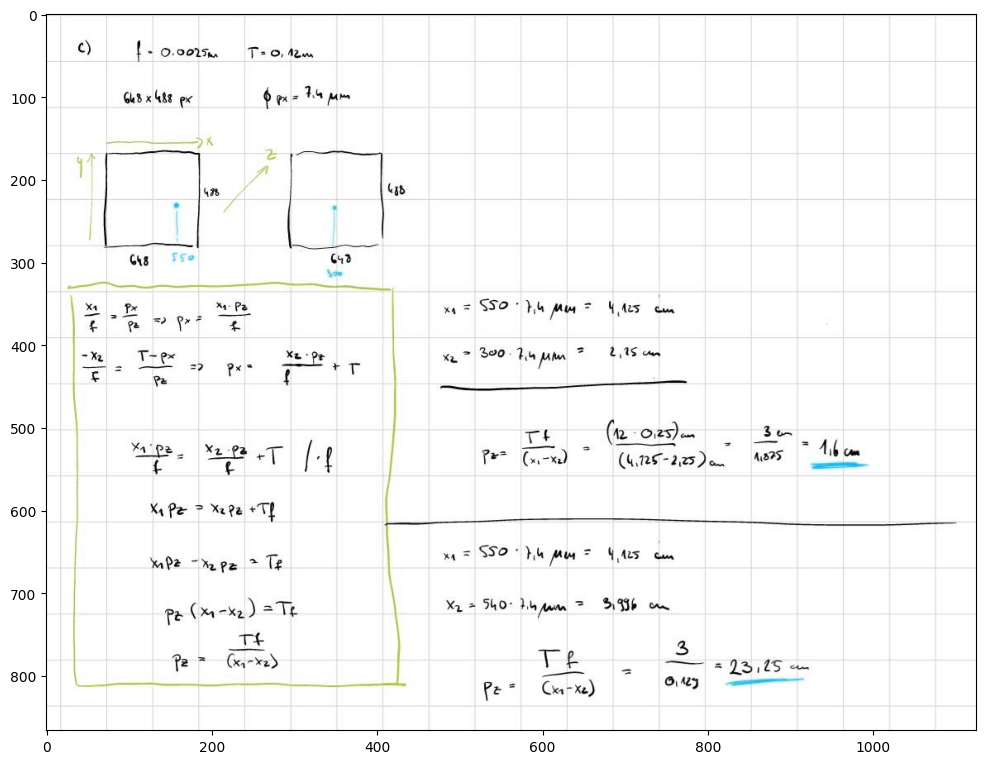

In [70]:
res = cv2.imread("1c.jpg")
fig, ax = plt.subplots(1,1,figsize=(12,12))

ax.imshow(res)

In [71]:
def hellinger(h1, h2):
    return np.sqrt(0.5 * np.sum(np.square(np.sqrt(h1) - np.sqrt(h2))))**2

### Exercise 2: Fundamental matrix, epipoles, epipolar lines

#### a) Analytically compute the equation of the epipolar line

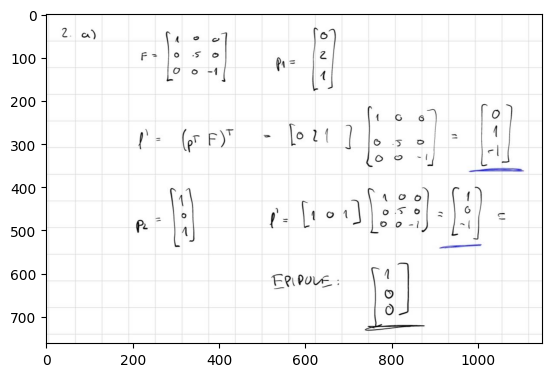

In [72]:
plt.imshow(cv2.imread("2a.jpg"))

#### b) Fundamental matrix estimation

In [73]:
def get_A(points1: np.ndarray, points2: np.ndarray) -> np.ndarray:
    A = []
    for p1, p2 in zip(points1, points2):
        x1, y1, z1 = p1
        x2, y2, z2 = p2
        
        row = [x1*x2, x2*y1, x2, x1*y2, y1*y2, y2, x1, y1, 1]
        A.append(row)
    A = np.array(A)
    return A
    

In [134]:
from a5_utils import *

def fundamental_matrix(points1: np.ndarray, points2: np.ndarray) -> np.ndarray:
    '''
        Computes an estimation of the fundamental matrix F, needs at least 8 pairs of points as input
    '''

    points1, T1 = normalize_points(points1)        
    points2, T2 = normalize_points(points2)        
    
    # Compute F'
    A = get_A(points1, points2)
    
    U, D, VT = np.linalg.svd(A)
    
    F = VT[-1]
    F = np.reshape(F, (3,3))

    # Enforce the constraint
    U, D, VT = np.linalg.svd(F) # This returns singular values in a vector, not a matrix

    D = np.array([[D[0], 0, 0],
                  [0, D[1], 0],
                  [0, 0, D[2]]])

    D[2,2] = 0

    F = np.matmul(U, np.matmul(D, VT))
    
    
    # F = T2.T * F' * T1
    F = np.matmul(T2.T, np.matmul(F, T1))
    return F

In [75]:
def get_epipoles(F: np.ndarray) -> np.ndarray:
    '''
        Computes both epipolar lines by SVD of the fundamental matrix
    '''
    U,D,VT = np.linalg.svd(F)
    
    e1 = VT[-1] / VT[-1, -1]
    e2 = U[-1] / U[-1, -1]
    
    return e1, e2
    

2


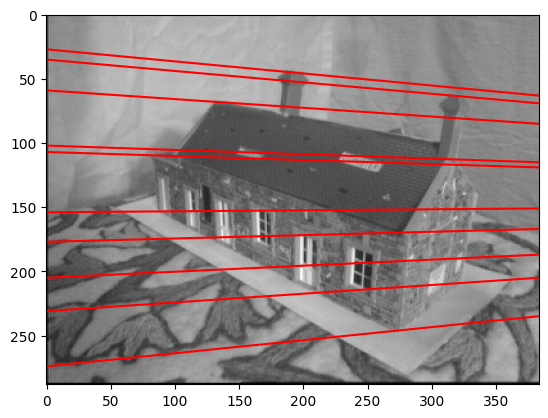

In [76]:
pts = np.loadtxt("data/epipolar/house_points.txt")
points1, points2 = [], []

for row in pts:
    points1.append((row[0], row[1]))
    points2.append((row[2], row[3]))
points1 = np.array(points1)
points2 = np.array(points2)

F = fundamental_matrix(points1, points2)
print(np.linalg.matrix_rank(F))

house1 = cv2.imread("data/epipolar/house1.jpg")
house1 = cv2.cvtColor(house1, cv2.COLOR_BGR2GRAY)

house2 = cv2.imread("data/epipolar/house2.jpg")
house2 = cv2.cvtColor(house2, cv2.COLOR_BGR2GRAY)

# Compute epipolar lines
epi1, epi2 = get_epipoles(F)


for p in points2:
    p = np.array([p[0], p[1], 1])
    
    epiline2 = np.matmul(p.T, F).T
    draw_epiline(epiline2, house2.shape[0], house2.shape[1])
    plt.imshow(house1, cmap="gray")
    


#draw_epiline(get_epipolar_lines(points1[0], epi1), house2.shape[0], house2.shape[1])
#ax[1].imshow(house2, cmap="gray")

    

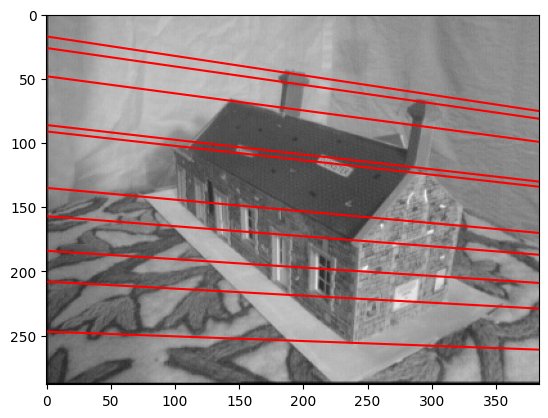

In [77]:
for p in points1:
    p = np.array([p[0], p[1], 1])
    epiline1 = np.matmul(F, p)
    draw_epiline(epiline1, house1.shape[0], house1.shape[1])
    plt.imshow(house2, cmap="gray")

#### c) Reprojection error

In [78]:
def distance(line: np.ndarray, point: tuple) -> float:
    return np.abs(line[0] * point[0] + line[1] * point[1] + line[2]) / np.sqrt(np.square(line[0]) + np.square(line[1]))

In [79]:
def reprojection_error(p1: tuple, p2: tuple, F: np.ndarray) -> float:
    pt1 = np.array([p1[0], p1[1], 1])
    pt2 = np.array([p2[0], p2[1], 1])
    
    # Point 1
    epiline1 = np.matmul(F, pt1)
    dist1 = distance(epiline1, p2)
    #print(epiline1, p1, dist1)
    
    epiline2 = np.matmul(pt2.T, F).T
    dist2 = distance(epiline2, p1)
    #print(epiline2, p2, dist2)    
    
    return np.average([dist1, dist2])
    
    

In [80]:
# (1)
err = reprojection_error((85, 233), (67, 219), F)
print(err)

0.14674365570458087


In [81]:
hpoints = np.loadtxt("data/epipolar/house_points.txt")
pts1, pts2 = [], []

for row in hpoints:
    pts1.append((row[0], row[1]))
    pts2.append((row[2], row[3]))
    
errors = []
for pt1, pt2 in zip(pts1, pts2):
    errors.append(reprojection_error(pt1, pt2, F))

error = np.average(errors)
print(error)

0.33091336980543307


#### d) Fully automatic fundamental matrix estimation

In [125]:
def match_keypoints(descriptor1, descriptor2):
    '''
        Takes in 2 arrays of feature point descriptors and matches each one from the first array to the closest one from the second one
        Returns an array of pairs of indices
    '''
    indices = []
    for i in range(len(descriptor1)):
        d1 = descriptor1[i]
        
        min_dist = 10000;
        min_desc = -1
              
        for j in range(len(descriptor2)):
            d2 = descriptor2[j]
            
            dist = hellinger(d1, d2)
            if dist < min_dist:
                min_dist = dist
                min_desc = j
        indices.append((i, min_desc))
    return indices

In [173]:
def get_matches(descriptors1, descriptors2):
    matcher = cv2.BFMatcher(cv2.NORM_L2)
    return matcher.match(descriptors1, descriptors2)

In [278]:
def get_correspondences(img1, img2):
    sift = cv2.SIFT_create(200)
    
    kpoints1, descriptors1 = sift.detectAndCompute(img1, None)
    kpoints2, descriptors2 = sift.detectAndCompute(img2, None)
    
    #matches = match_keypoints(descriptors1, descriptors2)
    matches = get_matches(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)
    
    matches1, matches2 = [], []
    for m in matches:
        matches1.append(kpoints1[m.queryIdx].pt)
        matches2.append(kpoints2[m.trainIdx].pt)
    
    fig, ax = plt.subplots(1,1,figsize=(20,10))
    img3 = cv2.drawMatches(img1, kpoints1, img2, kpoints2, matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    ax.imshow(img3)
    
    return np.array(matches1), np.array(matches2)

In [249]:
def get_inliers(correspondences, F, thresh=12):
    pts1, pts2 = correspondences
   
    inliers = []
    
    for pt1, pt2 in zip(pts1, pts2):
        dist = reprojection_error((pt1[0],pt1[1]), (pt2[0],pt2[1]), F)
        
        if dist < thresh:
            inliers.append((pt1, pt2))
        
    return inliers, len(inliers)    

In [280]:
def ransac(points, dist_threshold=5, inlier_threshold=5, n_iter=30):
    
    inliers = []
    best_inliers = []
    best_F = []
    max_inliers = 0
    pts1, pts2 = points
    
    for i in range(n_iter):

        # Choose a random subset
        if len(inliers) < 8:
            indices = np.random.randint(pts1.shape[0], size=8)
            correspondences = np.array([pts1[indices], pts2[indices]])
        else:
            indices = np.random.randint(inliers[0].shape[0], size=8)
            correspondences = np.array([inliers[0][indices], inliers[1][indices]])        
        
        # Estimate F
        F = fundamental_matrix(correspondences[0], correspondences[1])
        
        # Determine inliers
        inliers, n_inliers = get_inliers(correspondences, F)
        inliers = np.array(inliers)
        
        if n_inliers > inlier_threshold:
            if n_inliers > max_inliers:
                max_inliers = n_inliers
                best_inliers = inliers
                best_F = F
        else: inliers = []
    
    
    if len(best_inliers) >= 8:
        F = fundamental_matrix(pts1, pts2)
    return F
    
    
    

In [267]:
def estimate_fundamental_matrix(img1, img2):
    # Detect correspondeces
    points1, points2 = get_correspondences(img1, img2)
        
    correspondences = np.array([pts1, pts2]) # [[[x1, y1], [...]], [x2, y2], [....]]]
    
    F = ransac(correspondences)    
    
    return pts1, pts2, F
    # Ransac

LinAlgError: SVD did not converge

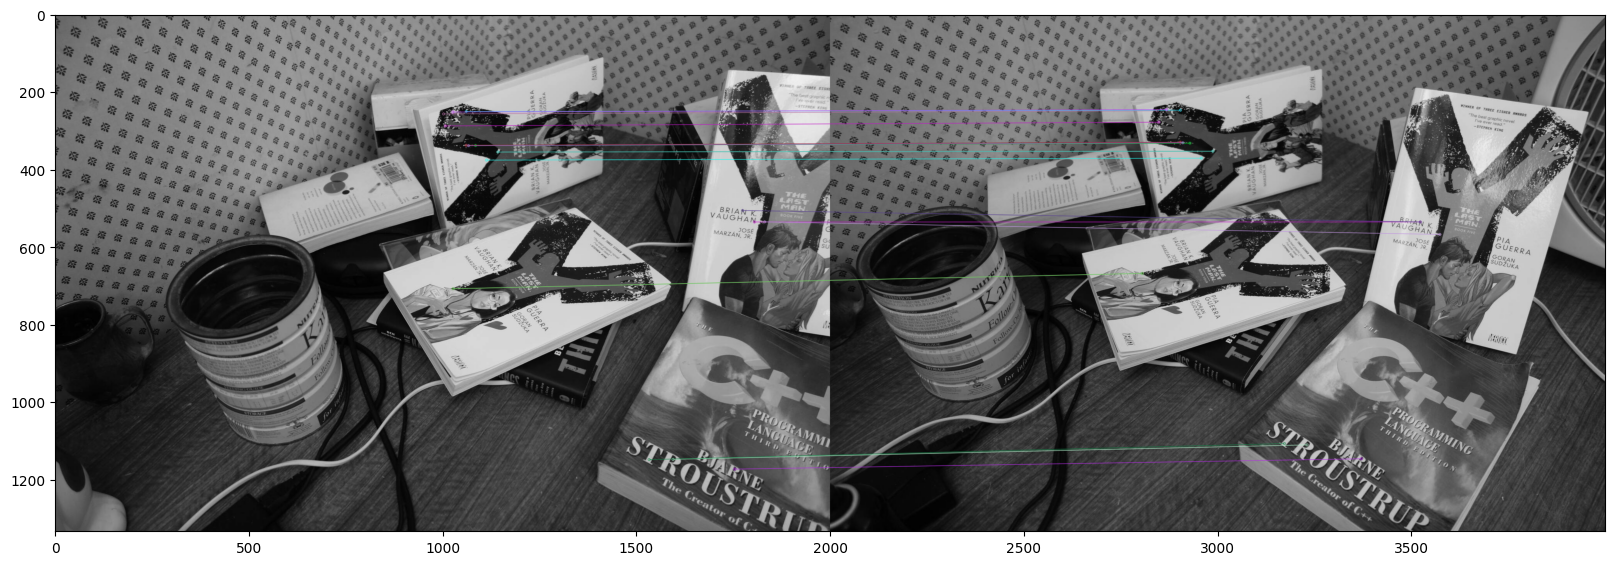

In [281]:
img1 = cv2.imread("data/desk/DSC02638.JPG")
img2 = cv2.imread("data/desk/DSC02639.JPG")

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#fig, ax = plt.subplots(1,2, figsize=(10,10))

pts1, pts2, F = estimate_fundamental_matrix(img1, img2)

#fig, ax = plt.subplots(1,2, figsize=(10,10))
#
#xs = list(map(lambda x: x[0], pts1))
#ys = list(map(lambda x: x[1], pts1))
#
#ax[0].scatter(xs, ys, marker="x", c="red")
#ax[0].imshow(img1, cmap="gray")
#
#xs = list(map(lambda x: x[0], pts2))
#ys = list(map(lambda x: x[1], pts2))
#
#ax[1].scatter(xs, ys, marker="x", c="red")
#ax[1].imshow(img2, cmap="gray")
#
## Compute epipolar lines
#epi1, epi2 = get_epipoles(F)

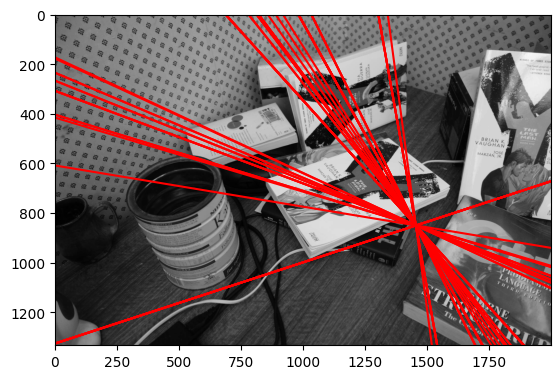

In [276]:
for p in pts2:
    p = np.array([p[0], p[1], 1])
    
    epiline2 = np.matmul(p.T, F).T
    draw_epiline(epiline2, img1.shape[0], img1.shape[1])
plt.imshow(img1, cmap="gray")
    

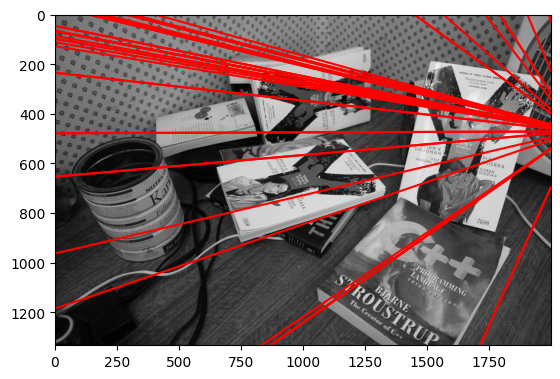

In [277]:
for p in pts1:
    p = np.array([p[0], p[1], 1])
    
    epiline1 = np.matmul(F, p)
    draw_epiline(epiline1, img2.shape[0], img2.shape[1])
plt.imshow(img2, cmap="gray")

### Exercise 3: Triangulation

#### a) Triangulation

In [ ]:
def get_A(x1: tuple, x2: tuple, P1: np.ndarray, P2: np.ndarray) -> np.ndarray:
    
    x1 = np.array([[0, -1, x1[1]],
                   [1, 0, -x1[0]],
                   [-x1[1], x1[0], 0]])    
    
    x2 = np.array([[0, -1, x2[1]],
                   [1, 0, -x2[0]],
                   [-x2[1], x2[0], 0]])    
        
    
    upper_half = np.matmul(x1, P1)[:3]
    bottom_half = np.matmul(x2, P2)[:3]

    A = np.concatenate((upper_half, bottom_half))
    return A

In [ ]:
def triangulate(points: np.ndarray, projection_matrices: np.ndarray) -> np.ndarray:
    #     [ [X1x]P1 ]
    # A = [ [X2x]P2 ]
    #
    points_3d = []
    pts1, pts2 = points
    P1, P2 = projection_matrices
    
    for pt1, pt2 in zip(pts1, pts2):
        A = get_A(pt1, pt2, P1, P2)
        U, D, VT = np.linalg.svd(A)
        
        X = VT[-1]
        X /= X[3]
        
        points_3d.append(X)
    
    return points_3d

True


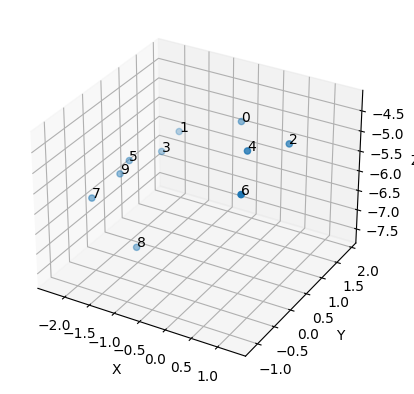

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
P1 = np.loadtxt("data/epipolar/house1_camera.txt")
P2 = np.loadtxt("data/epipolar/house2_camera.txt")

hpoints = np.loadtxt("data/epipolar/house_points.txt")
pts1, pts2 = [], []

for row in hpoints:
    pts1.append((row[0], row[1]))
    pts2.append((row[2], row[3]))
   
points_3d = triangulate([pts1, pts2], [P1, P2])

T = np.array([[-1,0,0],
              [0,0,1],
              [0,-1,0]])

xs, ys, zs = [], [], []
for point in points_3d:
    xs.append(point[0])
    ys.append(point[1])
    zs.append(point[2])

#fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': '3d'})

plt.ion()
print(plt.isinteractive())
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
i = 0
for point in points_3d:
    ax.text(point[0], point[1], point[2], f"{i}")
    i += 1
    

ax.scatter(xs, ys, zs)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

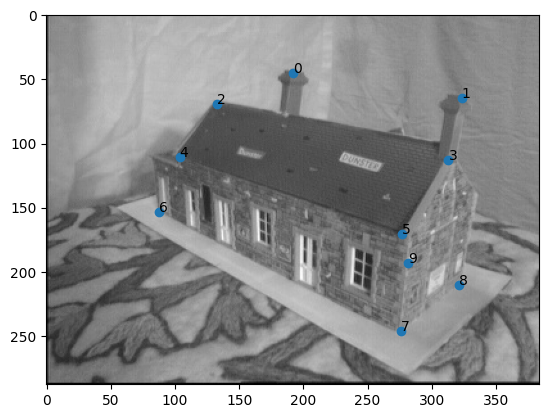

In [ ]:
pts1_x = [] 
pts1_y = []

i = 0
for pt in pts1:
    pts1_x.append(pt[0])
    pts1_y.append(pt[1])
    plt.text(pt[0], pt[1], i)  
    i+=1  
    
plt.scatter(pts1_x, pts1_y)
plt.imshow(house1, cmap="gray")

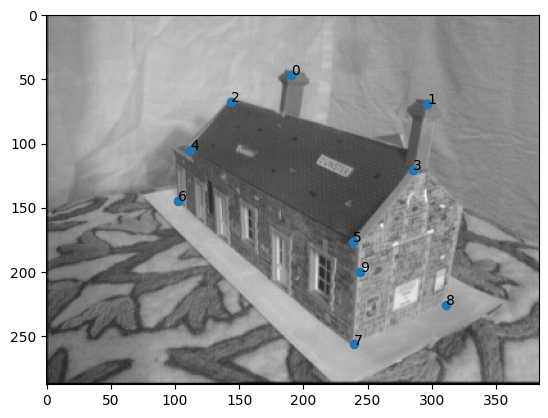

In [ ]:
pts2_x = [] 
pts2_y = []

i = 0
for pt in pts2:
    pts2_x.append(pt[0])
    pts2_y.append(pt[1])
    plt.text(pt[0], pt[1], i)  
    i+=1  
    
plt.scatter(pts2_x, pts2_y)
plt.imshow(house2, cmap="gray")